In [ ]:
import re
import os, glob, datetime, time
import shutil
import random
import math
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from matplotlib import pyplot as plt

import scipy.io
import scipy.ndimage
import numpy as np
import seaborn as sns
import plotly.express as px

import torch
from torch import nn, einsum
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm
import torch.nn.init as init
import torch.nn.functional as F

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed = 123789
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
def sam(x_true, x_pred):
    assert x_true.ndim ==3 and x_true.shape == x_pred.shape
    h,w,c=x_pred.shape
    sam_rad = []
    for x in range(x_true.shape[0]):
        for y in range(x_true.shape[1]):
            tmp_pred = x_pred[x, y].ravel()
            tmp_true = x_true[x, y].ravel()

            s = np.sum(np.dot(tmp_pred, tmp_true))
            t = (np.sqrt(np.sum(tmp_pred ** 2))) * (np.sqrt(np.sum(tmp_true ** 2)))
            th = np.arccos(s/t)
            sam_rad.append(th)
    sam_deg = np.mean(sam_rad)
    return sam_deg

def quantitative_assess(data_clean,test_out):
    psnrs=[]
    ssims=[]
    height,width,band =data_clean.shape
    for b in range(band):
        psnr1 = peak_signal_noise_ratio(data_clean[:, :, b], test_out[:, :, b],data_range=1)
        ssim1 = structural_similarity(data_clean[:, :, b], test_out[:, :, b],win_size=11,data_range=1,gaussian_weights=1)

        psnrs.append(psnr1)
        ssims.append(ssim1)
    avg_psnr = np.mean(psnrs)
    avg_ssim = np.mean(ssims)
    Sam=sam(data_clean,test_out)
    return [avg_psnr,avg_ssim,Sam]



---



---



---


# **Testing Model**

In [ ]:
cfg = ([64, 1], [64, 1], [64, 1],
       [128, 1], [128, 1], [128, 1],
       [256, 2], [256, 2], [256, 2],
       [128, 1], [128, 1], [128, 1],
       [64, 1], [64, 1], [64, 1], [64, 1])

class DeNet(nn.Module):
    def __init__(self, kernel_size=3, init_weights=True):
        super(DeNet, self).__init__()
        layers = []
        layer_output = 1
        final_channels = 1
        out_channels = 64
        layers.append(nn.Conv2d(
            in_channels=layer_output, out_channels=out_channels,
            kernel_size=kernel_size, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))
        in_channels = out_channels
        for out_channels, dilation in cfg:
            if dilation == 1:
                padding = 1
            elif dilation == 2:
                padding = 2
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                    kernel_size=kernel_size, padding=padding,
                                    dilation=dilation, bias=False)
                          )
            layers.append(nn.BatchNorm2d(num_features=out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels

        layers.append(nn.Conv2d(in_channels=64, out_channels=final_channels,
                      kernel_size=kernel_size, padding=1, bias=False)
                      )
        self.denet = nn.Sequential(*layers)

    def forward(self, Spatial):
        out = self.denet(Spatial)
        return Spatial - out

In [ ]:
# # Train and Dataset
# spatial = torch.randn(24,1,20,20).cuda()

# model = DeNet().cuda()
# output = model(spatial)
# output.shape



---



---



---



In [ ]:
TestData = "/content/drive/MyDrive/DC_Mall TestDataset Original_Noise_Gaussian30_Data.mat"
TrainData = "/content/drive/MyDrive/DC_Mall TrainDataset Original_Noise_Gaussian30_Augmentation_Data.mat"

#TEST DATA

test_data_DC = scipy.io.loadmat(TestData)
test_data_clean_DC = test_data_DC['original']
test_data_noise_DC = test_data_DC['noise']

#TRAIN DATA
data = scipy.io.loadmat(TrainData)
data_clean = data['original']
data_noise = data['noise']

number, heigth, width, band = data_clean.shape
data = np.zeros((2, number, heigth, width, band))
for n in range(number):
    data[0, n, :, :, :] = data_clean[n, :, :, :]
    data[1, n, :, :, :] = data_noise[n, :, :, :]
data = torch.from_numpy(data.transpose((1, 0, 4, 2, 3)))

In [ ]:
test_data_clean_DC.shape, test_data_noise_DC.shape, data.shape

((200, 200, 191), (200, 200, 191), torch.Size([24, 2, 191, 20, 20]))

In [ ]:
batch_size = 24
argsK = 24
n_epoch = 100
k = int(argsK/2)

milestone=[180]
lr = 1e-5

cuda = torch.cuda.is_available()
print("cuda is ",cuda)

# argument_sigma_role = "sigma_50" # Sigma Noise (5,25,50,75,100)
# argument_sigma_role = "Random_25" # Random Noise (25)
argument_sigma_role = "Gaussian_200_30" # Gaussian Noise (200,30)


if os.path.isdir(f"DeNet_Denoising_{argument_sigma_role}"):
  shutil.rmtree(f"DeNet_Denoising_{argument_sigma_role}")
  print(f"Delete DeNet_Denoising_{argument_sigma_role} Folder")
if not os.path.exists(f'DeNet_Denoising_{argument_sigma_role}'):
  os.makedirs(f'DeNet_Denoising_{argument_sigma_role}')
  print(f"Create DeNet_Denoising_{argument_sigma_role} Folder")
else:
  pass

save_dir = os.path.join('model')
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    print("Delete Model Folder")
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
  print("Create Model Folder")
else:
  pass

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

DLoader = DataLoader(dataset=data, num_workers=0, drop_last=False, batch_size=batch_size, shuffle=True)

model = DeNet()

if cuda:
  model = model.cuda()

criterion = nn.L1Loss().cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer, milestones=milestone, gamma=0.2)

cuda is  True
Create DeNet_Denoising_Gaussian_200_30 Folder
Create Model Folder


In [ ]:
psnrs_matric, ssims_matric, sams_matric, time_train, time_test = list(), list(), list(), list(), list()
for epoch in range(0, n_epoch):
  model.train()
  lr = optimizer.state_dict()['param_groups'][0]['lr']
  epoch_loss = 0
  start_time = time.time()

  for _, batch_yx in enumerate(DLoader):
    optimizer.zero_grad()
    if cuda:
      batch_x, batch_y = batch_yx[:,0,:,:].cuda(), batch_yx[:,1,:,:].cuda()

    iter_band = np.arange(band)
    np.random.shuffle(iter_band)

    for b in iter_band:
      x = batch_y[:,b, :, :]
      noise_free = batch_x[:,b, :, :]

      x = torch.unsqueeze(x, dim=1).type(torch.FloatTensor)
      noise_free = torch.unsqueeze(noise_free, dim=1).type(torch.FloatTensor)

      if cuda:
        x = x.cuda()
        noise_free = noise_free.cuda()

      learned_image=model(x)
      loss = criterion(learned_image, noise_free)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()

  scheduler.step()
  batch_number = data.size(0) // batch_size
  final_time = time.time() - start_time
  time_train.append(final_time)

  if(epoch<n_epoch):
    model.eval()
    data_noise = torch.from_numpy(test_data_noise_DC)
    hight,width,cs=data_noise.shape
    data_noise = data_noise.permute(2, 1, 0)
    test_out = torch.zeros(data_noise.shape).type(torch.FloatTensor)

    start_time_test = time.time()
    for channel_i in range(cs):
      x_data = data_noise[channel_i, :, :]
      x_data = torch.unsqueeze(x_data, dim=0).type(torch.FloatTensor)
      x_data = torch.unsqueeze(x_data, dim=0).type(torch.FloatTensor)

      if cuda:
        x_data = x_data.cuda()
      with torch.no_grad():
        out = model(x_data)

      out = out.squeeze()
      test_out[channel_i,:,:] = out

    end_time_test = time.time() - start_time_test
    time_test.append(end_time_test)

    test_out = test_out.permute(2,1,0)
    denoise_image_out = test_out.cpu().numpy()

    PSNR,SSIM,SAM = quantitative_assess(test_data_clean_DC, denoise_image_out)
    psnrs_matric.append(PSNR)
    ssims_matric.append(SSIM)
    sams_matric.append(SAM)


  total_epoch_loss = epoch_loss / batch_number
  print(f"Epoch : {epoch+1}/{n_epoch} and Loss : ({total_epoch_loss:.5f}) and (PSNR : {PSNR} & SSIM : {SSIM} & SAM : {SAM}) and Train Time : ({final_time:.1f}) Sec and Test Time : ({end_time_test:.1f}) Sec")

  torch.save(model, os.path.join(save_dir, 'model_%03d.pth' % (epoch + 1)))
  checkpoint = {
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                'lr_schedule': scheduler.state_dict()
              }
  torch.save(checkpoint, os.path.join(save_dir, 'checkpoint_%03d.pth' % (epoch + 1)))

Epoch : 1/100 and Loss : (17.46157) and (PSNR : 0.9687800610959029 & SSIM : 0.45054299601217423 & SAM : 0.8585465550422668) and Train Time : (18.3) Sec and Test Time : (9.7) Sec
Epoch : 2/100 and Loss : (8.63863) and (PSNR : -1.0976595699432832 & SSIM : 0.5896796214961056 & SAM : 0.9781175851821899) and Train Time : (9.5) Sec and Test Time : (9.9) Sec
Epoch : 3/100 and Loss : (9.27094) and (PSNR : -10.801499688112996 & SSIM : 0.6090413481816558 & SAM : 1.1064985990524292) and Train Time : (9.6) Sec and Test Time : (10.0) Sec
Epoch : 4/100 and Loss : (9.86732) and (PSNR : -2.4192530297712773 & SSIM : 0.6076880029836416 & SAM : 0.4206617772579193) and Train Time : (9.7) Sec and Test Time : (10.0) Sec
Epoch : 5/100 and Loss : (8.22511) and (PSNR : -0.997027013380684 & SSIM : 0.724203866802229 & SAM : 0.6152212619781494) and Train Time : (9.8) Sec and Test Time : (10.3) Sec
Epoch : 6/100 and Loss : (7.19165) and (PSNR : 0.5231678504260112 & SSIM : 0.7153187526222718 & SAM : 0.3584824204444

In [ ]:
 # psnrs, ssims, sam
psnr_max, psnr_std = np.amax(psnrs_matric), np.std(psnrs_matric, ddof=1)
ssim_max, ssim_std = np.amax(ssims_matric), np.std(ssims_matric, ddof=1)
sam_max, sam_std = np.amin(sams_matric), np.std(sams_matric, ddof=1)
traintime_average, testtime_average = np.average(final_time), np.average(time_test)

from prettytable import PrettyTable
pt = PrettyTable()
print(f"Note: Improvements shown are over original pairs of Hyperspectral Image using {argument_sigma_role}")
pt.field_names = ["Model", "MPSNR", "MSSIM", "MSAM", "TRAIN_TIME", "TESTTIME"]

pt.add_row(["DeNet Denoising Model ","{:.4f} ± {:.4f}".format(psnr_max, psnr_std),"{:.4f} ± {:.4f}".format(ssim_max,ssim_std),"{:.4f} ± {:.4f}".format(sam_max,sam_std), "Average {:.4f}".format(traintime_average), "Average {:.4f}".format(testtime_average)])
data = pt.get_string()
with open(f'./DeNet_Denoising_{argument_sigma_role}/DeNet_Denoising_{argument_sigma_role}.txt', 'w') as f: f.write(data)
print(pt)

Note: Improvements shown are over original pairs of Hyperspectral Image using Gaussian_200_30
+------------------------+-------------------+-----------------+-----------------+-----------------+-----------------+
|         Model          |       MPSNR       |      MSSIM      |       MSAM      |    TRAIN_TIME   |     TESTTIME    |
+------------------------+-------------------+-----------------+-----------------+-----------------+-----------------+
| DeNet Denoising Model  | 28.9257 ± 12.0762 | 0.9217 ± 0.1058 | 0.1724 ± 0.2174 | Average 10.2759 | Average 10.6780 |
+------------------------+-------------------+-----------------+-----------------+-----------------+-----------------+


In [ ]:
data = {
    "PSNR": psnrs_matric,
    "SSIM": ssims_matric,
    "SAM": sams_matric,
    "TrainTime": final_time,
    "TestTime": time_test,
}
import pandas as pd
data = pd.DataFrame().from_dict(data)
data.to_csv(f'./DeNet_Denoising_{argument_sigma_role}/DeNet_Denoising_PSNR_SSIM_SAM_BANDS_CSVFILE_{argument_sigma_role}.csv', index=False)
data

,PSNR,SSIM,SAM,TrainTime,TestTime
0,0.968780,0.450543,0.858547,10.275908,9.716998
1,-1.097660,0.589680,0.978118,10.275908,9.896793
2,-10.801500,0.609041,1.106499,10.275908,9.983791
3,-2.419253,0.607688,0.420662,10.275908,10.033635
4,-0.997027,0.724204,0.615221,10.275908,10.272269
...,...,...,...,...,...
95,14.400895,0.902117,0.193876,10.275908,10.676235
96,9.270612,0.890379,0.200061,10.275908,10.711028
97,8.795753,0.880787,0.211749,10.275908,10.672191
98,11.796220,0.894057,0.196748,10.275908,10.674850


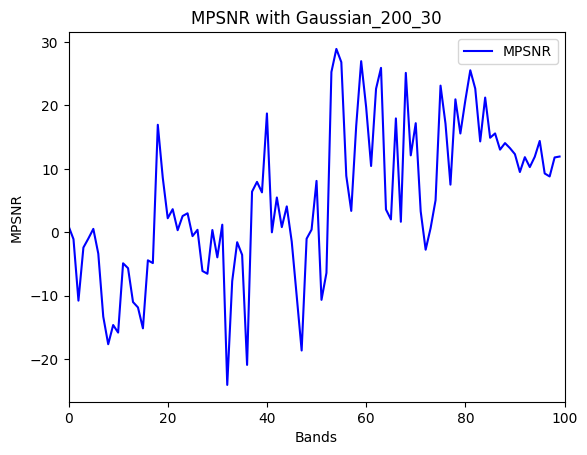

In [ ]:
epochs = range(0, 100)
plt.plot(epochs, psnrs_matric, 'b', label='MPSNR')
plt.title(f'MPSNR with {argument_sigma_role}')
plt.xlabel('Bands')
plt.ylabel('MPSNR')
plt.legend()
plt.xlim(0,100)
plt.savefig(f'./DeNet_Denoising_{argument_sigma_role}/DeNet_Denoising_Graph_MPSNR_{argument_sigma_role}.png')
plt.show()

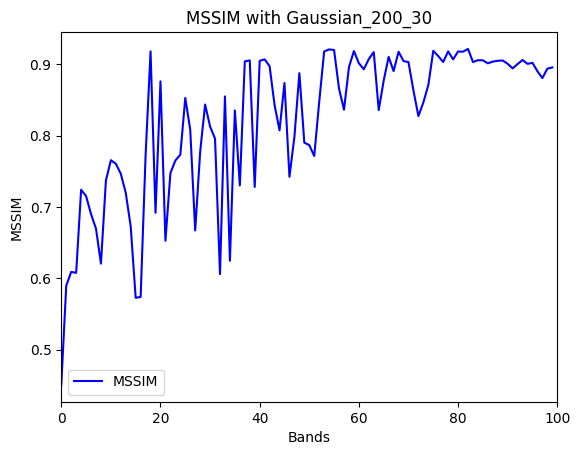

In [ ]:
epochs = range(0, 100)
plt.plot(epochs, ssims_matric, 'b', label='MSSIM')
plt.title(f'MSSIM with {argument_sigma_role}')
plt.xlabel('Bands')
plt.ylabel('MSSIM')
plt.legend()
plt.xlim(0,100)
plt.savefig(f'./DeNet_Denoising_{argument_sigma_role}/DeNet_Denoising_Graph_MSSIM_{argument_sigma_role}.png')
plt.show()

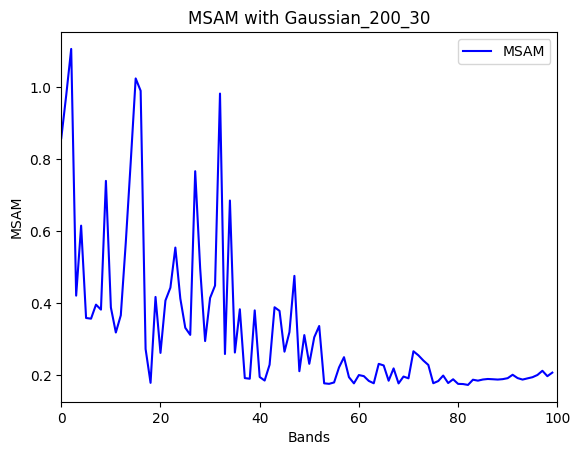

In [ ]:
epochs = range(0, 100)
plt.plot(epochs, sams_matric, 'b', label='MSAM')
plt.title(f'MSAM with {argument_sigma_role}')
plt.xlabel('Bands')
plt.ylabel('MSAM')
plt.legend()
plt.xlim(0,100)
plt.savefig(f'./DeNet_Denoising_{argument_sigma_role}/DeNet_Denoising_Graph_MSAM_{argument_sigma_role}.png')
plt.show()

In [ ]:
def show_image(data_noise,test_out,data_clean):
  def Noise_Image():
    fig = plt.figure(frameon=False, figsize = (5, 5))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    plt.imshow(data_noise[:, :, (56,25,16)])
    plt.savefig(f"./DeNet_Denoising_{argument_sigma_role}/DCMall_Noise_{argument_sigma_role}.png")
    plt.axis('off')
    plt.title('noise image')
  def Denoise_Image():
    fig = plt.figure(frameon=False, figsize = (5, 5))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    plt.imshow(test_out[:, :, (56,25,16)])
    plt.savefig(f"./DeNet_Denoising_{argument_sigma_role}/DCMall_Denoise_{argument_sigma_role}.png")
    plt.axis('off')
    plt.title('denoise image')
  def Clean_Image():
    fig = plt.figure(frameon=False, figsize = (5, 5))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    plt.imshow(data_clean[:, :, (56,25,16)])
    plt.savefig(f"./DeNet_Denoising_{argument_sigma_role}/DCMall_Clean_{argument_sigma_role}.png")
    plt.axis('off')
    plt.title('clean image')

  Noise_Image()
  Denoise_Image()
  Clean_Image()
  plt.show()

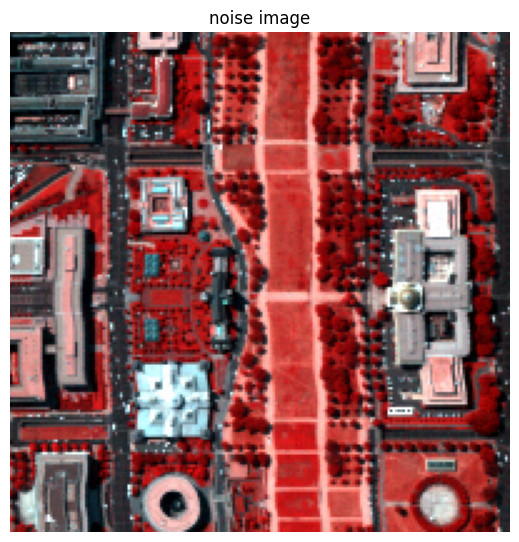

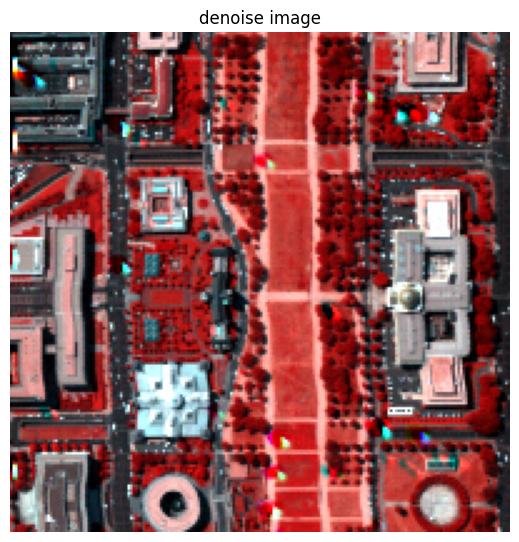

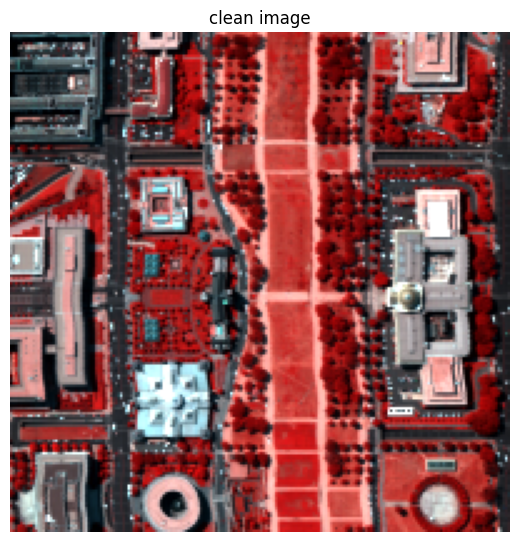

In [ ]:
show_image(test_data_noise_DC,denoise_image_out,test_data_clean_DC)

In [ ]:
scipy.io.savemat(f"./DeNet_Denoising_{argument_sigma_role}/Washington DC Mall University_Denoise_{argument_sigma_role}_Dataset_Image.mat",{'Image': denoise_image_out})